# Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
import pandas as pd
import numpy as np
import re
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import OneHotEncoder

# Data Parsing

### Load dataset

In [18]:
df = pd.read_csv('./data/dataSetB.csv')
df = df[[col for col in df if "NameRxn" in col]]

In [ ]:
# df_train = pd.read_csv('./data/canonicalized_csv/train.csv')
# df_valid = pd.read_csv('./data/canonicalized_csv/train.csv')
# df_test = pd.read_csv('./data/canonicalized_csv/test.csv')

### Smiles to Reactions

In [ ]:

# def smiles_to_rxns(df):
#     rxn_list = []
#     for idx, row in df.iterrows():
#         reactants, products = row['rxn_smiles'].split('>>')

#         reactants = reactants.split('.')
#         products = products.split('.')

#         reactant_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants]
#         product_mols = [Chem.MolFromSmiles(product) for product in products]

#         rxn_list.append((reactant_mols,product_mols))
#     return rxn_list

In [ ]:
# train_rxns = smiles_to_rxns(df_train)
# validation_rxns = smiles_to_rxns(df_valid)
# test_rxns = smiles_to_rxns(df_test)

In [20]:
def parse_rxn_smile(rxn_smile,reactant_set):
    before_rxn_smile, products_smile = rxn_smile.split('>>')

    reactant_indices = [int(x) for x in re.findall(r'\d+', reactant_set)]

    potential_reactants = before_rxn_smile.split('.')
    reactants = [potential_reactants[idx] for idx in reactant_indices]

    products = products_smile.split('.')

    return reactants,products

In [21]:
rxn_list = []
for idx, row in df.iterrows():
    rxn_smile = row['rxnSmiles_Mapping_NameRxn']
    reactant_set = row['reactantSet_NameRxn']

    reactants, products = parse_rxn_smile(rxn_smile,reactant_set)

    reactant_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants]
    product_mols = [Chem.MolFromSmiles(product) for product in products]

    rxn_list.append((reactant_mols,product_mols))


### Reaction cleanup

In [23]:
# problems_w = 0
# problems_e = 0
# i = 0
cleaned_rxn_list = []
for idx, rxn in enumerate(train_rxns):
    rd_rxn = rdChemReactions.ChemicalReaction()
    for rctnt in rxn[0]:
        rd_rxn.AddReactantTemplate(rctnt)
    for prdct in rxn[1]:
        rd_rxn.AddProductTemplate(prdct)

    warnings, errors = rd_rxn.Validate()
    if(not warnings and not errors and not len(rxn[1])>1):
        cleaned_rxn_list.append(rd_rxn)
    # problems_w+=warnings
    # problems_e+=errors
# print(problems_w,problems_e)

[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 36 28 35 34 37 32 30 29 31 33 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 31 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 49 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 65 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 35 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 28 26 27 29 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 40 38 41 34 35 42 36 37 39 43 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 20 
[21:57:02] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 30 
[21:57:02] mapped a

# Feature extraction

In [24]:
symbol_list = [
        'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 'Li', 'Na', 'K',
        'Mg', 'B', 'Sn', 'I', 'Se', 'unk'
    ]

hyb_list = [
    Chem.rdchem.HybridizationType.SP, 
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
    ]

bt_list = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC
]

sym_encoder = OneHotEncoder(sparse_output=False)
hyb_encoder = OneHotEncoder(sparse_output=False)
bt_encoder = OneHotEncoder(sparse_output=False)

sym_encoder.fit(np.array(symbol_list).reshape(-1,1))
hyb_encoder.fit(np.array(hyb_list).reshape(-1,1))
bt_encoder.fit(np.array(bt_list).reshape(-1,1))

def one_hot_encode(symbol,encoder):
    try: 
        return torch.tensor(encoder.transform(np.array([[symbol]])).reshape(-1))
    except:
        return torch.tensor(encoder.transform(np.array([['unk']])).reshape(-1))


In [25]:
def get_atom_features(atom):
    sym_one_hot = one_hot_encode(atom.GetSymbol(),sym_encoder)
    formal_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
    degree = torch.tensor([atom.GetDegree()], dtype=torch.float)
    total_hydrogens = torch.tensor([atom.GetTotalNumHs()], dtype=torch.float)
    valence = torch.tensor([atom.GetTotalValence()], dtype=torch.float)
    is_aromatic = torch.tensor([atom.GetIsAromatic()], dtype=torch.float)
    is_in_ring = torch.tensor([atom.IsInRing()], dtype=torch.float)
    hyb_one_hot = one_hot_encode(atom.GetHybridization(),hyb_encoder)
    
    features = torch.cat([sym_one_hot, formal_charge, degree, total_hydrogens, valence, is_aromatic, is_in_ring, hyb_one_hot])
    
    return features


def get_bond_features(bond):
    # bond type, conjugation, ring membership,  stereo config
    bt_one_hot = one_hot_encode(bond.GetBondType(),bt_encoder)
    is_conjugated = torch.tensor([bond.GetIsConjugated()],dtype=float)
    is_in_ring = torch.tensor([bond.IsInRing()],dtype=float)

    print(bt_one_hot)
    features = torch.cat([bt_one_hot,is_conjugated,is_in_ring])


    return(features)


In [131]:
atom = cleaned_rxn_list[0].GetReactants()[0].GetAtoms()[1]
bond = cleaned_rxn_list[0].GetReactants()[0].GetBonds()[1]
print(get_atom_features(atom))
print(get_bond_features(bond))

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 3., 0., 4., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)
tensor([1., 0., 0., 0.], dtype=torch.float64)
tensor([1., 0., 0., 0., 1., 0.], dtype=torch.float64)


In [ ]:
i = 0
for idx,rxn in enumerate(cleaned_rxn_list):
    products = rxn.GetProducts()
    if len(products)>2:
        i+=1
        print(idx)
        Draw.MolsToImage(products).show()

print(i)

# Input Preparation

In [26]:
def get_broken_bonds(reactants,products):
    reactant_bonds = set()
    product_bonds = set()
    for rc in reactants:
        for bond in rc.GetBonds():
            atom1_map = bond.GetBeginAtom().GetAtomMapNum()
            atom2_map = bond.GetEndAtom().GetAtomMapNum()

            if atom1_map and atom2_map:
                reactant_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    for pr in products:
        for bond in pr.GetBonds():
            atom1_map = bond.GetBeginAtom().GetAtomMapNum()
            atom2_map = bond.GetEndAtom().GetAtomMapNum()
            
            if atom1_map and atom2_map:
                product_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    broken_bonds = reactant_bonds - product_bonds
    formed_bonds = product_bonds - reactant_bonds

    return formed_bonds

In [ ]:
def rxn_to_graph(rxn):
    reactants = rxn.GetReactants()
    products = rxn.GetProducts()

    bonds = rxn.GetBonds()

    y = get_broken_bonds(reactants,products)

    atom_features_list = [get_atom_features(atom) for atom in products]
    bond_features_list = [get_bond_features(bond) for bond in bonds]
    
    

# Model Definition

In [43]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        
        # First Graph Attention Layer
        # It takes the input features and transforms them.
        # Multi-head attention outputs are concatenated, so the output size is hidden_channels * heads.
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        
        # Second Graph Attention Layer
        # This is the final layer. The input size must match the output size of conv1.
        # We use heads=1 for the final layer to get a single output embedding per node.
        # Alternatively, you could use multiple heads and average them by setting concat=False.
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        
        # 1. Apply the first GAT layer
        x = self.conv1(x, edge_index)
        
        # --- Activation changed to LeakyReLU ---
        x = F.leaky_relu(x)
        
        x = F.dropout(x, p=0.6, training=self.training)

        # 2. Apply the second GAT layer
        x = self.conv2(x, edge_index)

        return x

In [58]:
def evaluate(model, loader, device):
    """Evaluates the model on the data provided by the loader."""
    model.eval() # Set the model to evaluation mode

    with torch.no_grad():
        total_correct = 0
        total_nodes = 0
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out.argmax(dim=1) # Get the class with the highest score
            
            total_correct += int((pred == batch.y).sum())
            total_nodes += batch.num_nodes
        
        return total_correct / total_nodes

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

dataset = []

for _ in range(200): # Create a dummy dataset of 64 graphs
    num_nodes = torch.randint(10, 50, (1,)).item() # Random number of nodes
    num_features = 16
    num_classes = 7
    
    x = torch.randn(num_nodes, num_features)
    # Create random edges
    edge_src = torch.randint(0, num_nodes, (100,))
    edge_dst = torch.randint(0, num_nodes, (100,))
    edge_index = torch.stack([edge_src, edge_dst], dim=0)
    
    y = torch.randint(0, num_classes, (num_nodes,))
    
    dataset.append(Data(x=x, edge_index=edge_index, y=y))

loader = DataLoader(dataset, batch_size=16, shuffle=True)

Using cuda.


In [61]:
from tqdm import tqdm

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size : train_size + val_size]
test_dataset = dataset[train_size + val_size :]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # No need to shuffle for eval
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Instantiate model, optimizer, and loss function
model = GAT(in_channels=num_features, hidden_channels=8, out_channels=num_classes, heads=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# --- Training Loop ---
for epoch in (range(1, 51)):
    total_loss = 0
    progress_bar = loader
    # Iterate over the batches created by the DataLoader
    for batch in progress_bar:
        # 1. Move the batch of graphs to the GPU
        batch = batch.to(device)
        
        # 2. Clear gradients
        optimizer.zero_grad()
        
        # 3. Perform a forward pass
        out = model(batch.x, batch.edge_index)
        
        # 4. Compute loss
        loss = criterion(out, batch.y)
        
        # 5. Derive gradients and 6. Update parameters
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    

    val_acc = evaluate(model, val_loader, device)
    print(f'Epoch: {epoch:03d}, Avg. Loss: {total_loss / len(loader):.4f}, Val Acc: {val_acc:.4f}')

Epoch: 001, Avg. Loss: 2.7279, Val Acc: 0.1391
Epoch: 002, Avg. Loss: 1.9593, Val Acc: 0.1496
Epoch: 003, Avg. Loss: 1.9503, Val Acc: 0.1478
Epoch: 004, Avg. Loss: 1.9479, Val Acc: 0.1548
Epoch: 005, Avg. Loss: 1.9464, Val Acc: 0.1496
Epoch: 006, Avg. Loss: 1.9441, Val Acc: 0.1461
Epoch: 007, Avg. Loss: 1.9415, Val Acc: 0.1530
Epoch: 008, Avg. Loss: 1.9401, Val Acc: 0.1617
Epoch: 009, Avg. Loss: 1.9387, Val Acc: 0.1791
Epoch: 010, Avg. Loss: 1.9371, Val Acc: 0.1896
Epoch: 011, Avg. Loss: 1.9358, Val Acc: 0.1861
Epoch: 012, Avg. Loss: 1.9345, Val Acc: 0.1843
Epoch: 013, Avg. Loss: 1.9332, Val Acc: 0.1983
Epoch: 014, Avg. Loss: 1.9316, Val Acc: 0.1809
Epoch: 015, Avg. Loss: 1.9302, Val Acc: 0.1843
Epoch: 016, Avg. Loss: 1.9289, Val Acc: 0.1861
Epoch: 017, Avg. Loss: 1.9276, Val Acc: 0.1913
Epoch: 018, Avg. Loss: 1.9272, Val Acc: 0.2122
Epoch: 019, Avg. Loss: 1.9259, Val Acc: 0.2139
Epoch: 020, Avg. Loss: 1.9239, Val Acc: 0.2000
Epoch: 021, Avg. Loss: 1.9236, Val Acc: 0.2000
Epoch: 022, A

In [57]:
test_acc = evaluate(model, test_loader, device)
print(f'Final Test Accuracy: {test_acc:.4f}')

Final Test Accuracy: 0.2429


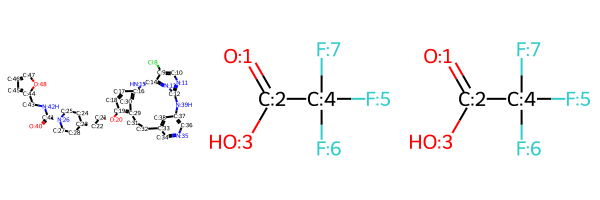

In [ ]:
mols =(rxn_list[26][1])
Draw.MolsToImage(mols).show()


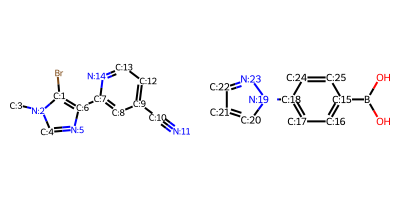

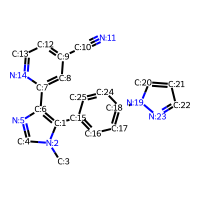

set() {(1, 15)}


In [ ]:
rcs, prs = rxn_list[5]
reactant_bonds = set()
product_bonds = set()
for rc in rcs:
    for bond in rc.GetBonds():
        atom1_map = bond.GetBeginAtom().GetAtomMapNum()
        atom2_map = bond.GetEndAtom().GetAtomMapNum()

        if atom1_map and atom2_map:
                # Add bond as a sorted tuple to handle order invariance
            reactant_bonds.add(tuple(sorted((atom1_map, atom2_map))))

for pr in prs:
    for bond in pr.GetBonds():
        atom1_map = bond.GetBeginAtom().GetAtomMapNum()
        atom2_map = bond.GetEndAtom().GetAtomMapNum()
        
        if atom1_map and atom2_map:
            product_bonds.add(tuple(sorted((atom1_map, atom2_map))))

broken_bonds = reactant_bonds - product_bonds
formed_bonds = product_bonds - reactant_bonds

Draw.MolsToImage(rcs).show()
Draw.MolsToImage(prs).show()

print(broken_bonds,formed_bonds)

['Cl.O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1.[BH3-]C#N.[CH3:44][CH2:45][NH:46][CH2:47][CH3:48].[Na+]', '[CH2:1]([c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1)[N:46]([CH2:45][CH3:44])[CH2:47][CH3:48]']


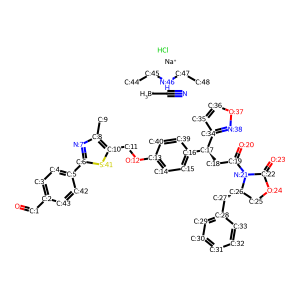

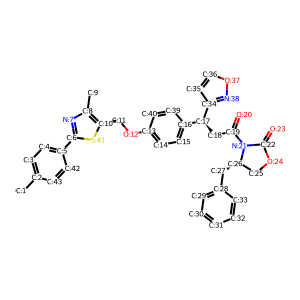

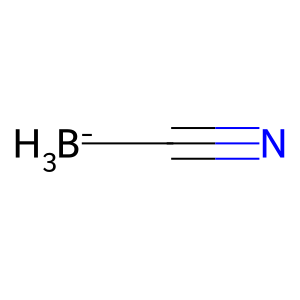

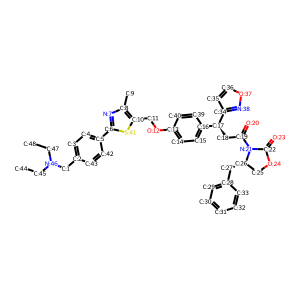

In [21]:


rxns = df[:100]['rxnSmiles_Mapping_NameRxn']

rxn = rxns[2]

splits = rxn.split('>>')

print(splits)

reac_smile = splits[0]
prod_smile = splits[1]

extras, delim, after = reac_smile.partition('[')
reac_smile2 = delim + after

reacs = reac_smile2.split(".")

all_reac = Chem.MolFromSmiles(reac_smile)
reac0 = Chem.MolFromSmiles(reacs[0])
reac1 = Chem.MolFromSmiles(reacs[1])
prod = Chem.MolFromSmiles(splits[1])

reac2 = Chem.MolFromSmiles(reacs[0])

# for atom in m.GetAtoms():
#     print(atom.GetAtomMapNum(),atom.GetDegree())
#     print(atom.)
Draw.MolToImage(all_reac).show()
Draw.MolToImage(reac0).show()
Draw.MolToImage(reac1).show()


Draw.MolToImage(prod).show()

In [45]:
print(Chem.SanitizeMol(reac_smile2))



ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.SanitizeMol(str)
did not match C++ signature:
    SanitizeMol(RDKit::ROMol {lvalue} mol, unsigned long sanitizeOps=rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, bool catchErrors=False)

In [ ]:
print(reac0.)

for bond in reac0.GetBonds():
    print(bond.GetIdx())

# for atom in reac0.GetAtoms():
#     print(atom.GetIdx())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
